<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/Consumer_types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.init as init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check for GPU availability and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", device)
    torch.cuda.init()
else:
    device = torch.device("cpu")
    print("GPU unavailable: Using CPU")

GPU available: cuda


In [ ]:
# Fixed Python random seed
random.seed(233)

# Fixed NumPy random seed
np.random.seed(233)

# Fixed PyTorch random seed
torch.manual_seed(233)

# Fixed CUDA randomness
if torch.cuda.is_available():
    torch.cuda.manual_seed(233)
    torch.cuda.manual_seed_all(233)  # 多GPU的情况
    torch.backends.cudnn.deterministic = True  # 确保 cudnn 计算是确定性的
    torch.backends.cudnn.benchmark = False  # 可能会影响性能，但保证可复现性

In [ ]:
# Define the Sales class for handling sales data and choice probability calculation
class Sales:
    def __init__(self, all_offer_sets, sell_num, mask):
        # all_offer_sets: list [offerset1: (num_products, num_features), offerset2: (num_products, num_features)...]
        # sell_num: nd.array (num_offers, num_products)
        # get the number of offers in a sales dataset
        self.offer_set_list = []
        self.fw = None
        self.N_sales = torch.tensor(np.concatenate(sell_num, axis=1), dtype=torch.float64, device=device)
        self.offer_feature = torch.tensor(all_offer_sets, dtype=torch.float64)
        self.original_shape = self.offer_feature.shape
        self.feature_concat = self.offer_feature.reshape(-1, self.offer_feature.shape[2]).to(device)
        self.N = torch.sum(self.N_sales)
        self.mask = torch.tensor(mask, dtype=torch.float64, device=device)
        self.mask_flat = self.mask.reshape((-1,))
        self.masked_feature_concat = self.feature_concat[self.mask_flat == 1]

    def calculate_all_choice_prob(self, W):
        # W: rule-weight taste vector (|Ruleset|, 1)
        # ruleset: Rule object
        rule_feature = self.feature_concat
        self.fw = self.calculate_choice_prob(rule_feature, W)
        return self.fw

    def calculate_choice_prob(self, rule_feature, W):
        """output choice probability tensor for every product"""
        # W: rule-weight taste vector (|Ruleset|, 1)
        # Z:  (｜St｜, |Ruleset|) * (|Ruleset|, 1) -> (｜St｜, 1)
        Z = torch.matmul(rule_feature, W).reshape(self.original_shape[:2])
        masked_Z = Z.masked_fill(self.mask == 0, float('-inf'))
        softmax_result = F.softmax(masked_Z, dim=-1).reshape((-1, 1))[self.mask_flat == 1]
        return softmax_result

In [ ]:
# Define the Problem_FW class to handle optimization using the Frank-Wolfe algorithm
class Problem_FW:
    def __init__(self, S, N, M):
        # S: [St] the list of offerset N: [Njt] the sales of jth product in St offer set
        self.alpha = torch.ones(1, dtype=torch.float64, device=device)
        self.soft_RMSE = None
        self.hard_RMSE = None
        self.fw_estimate = None
        self.sales = Sales(S, N, M)
        # Define and initialize the ruleset
        self.feature_num = S.shape[-1]
        # Put the feature to the GPU
        self.sales.feature_concat = self.sales.feature_concat.to(device)
        # Define a consumer list that contain consumer types
        self.consumer_list = []
        # Define the main problem NLL loss
        self.NLL_main = None
        # Define the current likelihood convex combination
        self.g = None
        # Define the current likelihood gradient for support finding
        self.NLL_gradient = None
        # Define a list to contain all fw choice likelihood
        self.fw_list = []
        # Define a new sales data for further estimation
        self.sales_estimate = None

    def initialize(self):
        # 1. We initialize a taste vector W
        W = torch.empty((self.feature_num, 1), dtype=torch.float64, device=device, requires_grad=True)
        a = 0
        b = 0
        init.uniform_(W, a, b)
        # 2. Add the initial consumer type in the consumer list
        initial_type = ConsumerType(
            W,
            torch.tensor([1], dtype=torch.float64, requires_grad=True, device=device),
            self.sales)
        self.consumer_list.append(initial_type)
        self.fw_list.append(initial_type.fw)
        # 4. Update the main problem NLL loss
        self.main_problem_loss()

    def main_problem_loss(self):
        """Here we calculate the NLL Loss for the main problem"""
        N = self.sales.N
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        N_sales = self.sales.N_sales
        # Now we get the combination of the consumer choice likelihood
        # this step can also be done by inner product by setting a tensor in problem to store all consumer data
        f = torch.zeros(N_sales.shape, dtype=torch.float64, device=device).t()
        for ct in self.consumer_list:
            f += ct.alpha * ct.fw
        f_log = torch.log(f)
        self.NLL_main = -normalize_term * torch.matmul(N_sales, f_log)
        # calculate the current g
        self.g = f
        # Update the gradient for the next support finding step
        with torch.no_grad():
            self.NLL_gradient = -normalize_term * torch.mul(1 / self.g.t(), N_sales)
        return self.NLL_main

    def support_finding_loss(self, W):
        """Here we calculate the Loss for the support finding step"""
        fw = self.sales.calculate_all_choice_prob(W)
        fw_log = torch.log(fw)
        return torch.matmul(self.NLL_gradient, fw_log)

    def proportion_update_loss(self, alpha):
        N = self.sales.N
        alpha = F.softmax(alpha, dim=0)
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        N_sales = self.sales.N_sales
        with torch.no_grad():
            fw_tensor = torch.cat(self.fw_list, dim=1)
        f = torch.matmul(fw_tensor, alpha)
        f_log = torch.log(f)
        return -normalize_term * torch.matmul(N_sales, f_log)

    def search_for_next_consumer_type(self):
        print('-----Consumer Type Search Begin-----')
        # Initialize the taste vector w
        W = torch.empty((self.feature_num, 1), dtype=torch.float64, device=device, requires_grad=True)
        a = -5e-1
        b = 5e-1
        init.uniform_(W, a, b)
        # The loss in the support find step i.e. the sub-problem in conditional gradient descent
        print('-----Rule Weight Optimization-----')
        loss_previous = 1e100
        optimizer = optim.Adam([W], lr=3e-4)
        optimizer.zero_grad()
        w_previous = None
        for epoch in range(2000):
            loss = self.support_finding_loss(W)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{2000}], Loss: {loss.item():.4f}')
            loss_current = loss.item()
            if loss_current < loss_previous:
                loss_previous = loss_current
                with torch.no_grad():
                    w_previous = W
            else:
                W = w_previous.requires_grad_(True)
                break

        new_consumer = ConsumerType(
            W,
            torch.tensor([0], dtype=torch.float64, device=device),
            self.sales)
        self.consumer_list.append(new_consumer)
        self.fw_list.append(new_consumer.fw)
        print('-----Consumer Type Search End-----')

    def proportion_update(self):
        print('-----Proportion Update Search Begin-----')
        # new_alpha = torch.zeros(1, requires_grad=True, dtype=torch.float64, device=device)
        # with torch.no_grad():
        #     alpha = torch.concatenate((self.alpha, new_alpha))
        # alpha = alpha.requires_grad_(True)
        alpha = torch.empty((len(self.consumer_list), 1), dtype=torch.float64, device=device, requires_grad=True)
        a = 0
        b = 0
        init.uniform_(alpha, a, b)
        optimizer = optim.Adam([alpha], lr=5e-3)
        optimizer.zero_grad()
        loss_previous = 1e100
        alpha_previous = None
        for epoch in range(1000):
            loss = self.proportion_update_loss(alpha)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{50000}], Loss: {loss.item():.4f}')
            loss_current = loss.item()
            if loss_current < loss_previous:
                loss_previous = loss_current
                with torch.no_grad():
                    alpha_previous = alpha
            else:
                alpha = alpha_previous.requires_grad_(True)
                break
        self.alpha = alpha
        alpha = F.softmax(alpha, dim=0)
        for i, consumer in enumerate(self.consumer_list):
            consumer.alpha = alpha[i]
        self.main_problem_loss()
        print('-----Proportion Update Search End-----')

In [ ]:
    def estimate_NLL(self, sales_for_estimate, N_estimate, mask_for_estimate):
            self.sales_estimate = Sales(sales_for_estimate, N_estimate, mask_for_estimate)
            N = self.sales_estimate.N
            normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
            N_sales = self.sales_estimate.N_sales
            f = torch.zeros(N_sales.shape, dtype=torch.float64, device=device).t()
            for ct in self.consumer_list:
                f += ct.alpha * self.sales_estimate.calculate_all_choice_prob(ct.taste)
            f_log = torch.log(f)
            return -normalize_term * torch.matmul(N_sales, f_log), f

    def estimate_rank(self, sales_for_estimate, N_estimate, mask_for_estimate):
        rank_list = []
        for o, s, msk in zip(sales_for_estimate, N_estimate, mask_for_estimate):
            prediction = self.estimate_NLL(np.array([o]),
                                           np.array([s]),
                                           np.array([msk]))[1].flatten().detach().cpu().numpy()
            choice = np.where(s[0] == 1)[0][0]
            value_at_index = prediction[choice]
            sorted_prediction = np.sort(prediction)
            rank = np.searchsorted(sorted_prediction, value_at_index, side='right')
            percentile_rank = (1 - (rank / len(s[0]))) * 100
            rank_list.append(percentile_rank)
        return rank_list


In [ ]:
class ConsumerType:
    def __init__(self, weight, alpha, problem_sales):
        # rule_weight (tensor): the weight of each rule in the consideration rules (|consideration_rule|, 1)
        self.taste = weight
        # alpha (float.64): the proportion of this type in the distribution
        self.alpha = alpha
        # fw: the choice likelihood vector for the consumer type
        # problem_sales: the sales object for this problem
        self.fw = problem_sales.calculate_all_choice_prob(self.taste)

In [ ]:
def train_frank_wolfe(type_num, tr_offerset_list, tr_sell_list, tr_mask_list):
    problem = Problem_FW(tr_offerset_list, tr_sell_list, tr_mask_list)
    problem.initialize()
    n = type_num
    NLL_LOSS_LIST = [problem.NLL_main.item()]
    for m in range(n):
        print('-----Consumer Type ' + str(m + 1) + ' Start Searching------')
        problem.search_for_next_consumer_type()
        problem.proportion_update()
        print('main problem loss: ', problem.NLL_main.item())
        print('-----One Iteration Done-----')
        NLL_LOSS_LIST.append(problem.NLL_main.item())
    for i in range(1, n + 1):
        print('-----Consumer Type ' + str(i) + '------')
        print('Consumer Proportion:', problem.consumer_list[i].alpha.item())
    return problem, NLL_LOSS_LIST


def get_offer_data(data_para):
    offerset_list = []
    sell_list = []
    mask_list = []
    max_num = 32
    for srch_id, group in data_para:
        num_product = len(group)
        offerset = group.drop(columns=['booking_bool', 'srch_id']).values
        offer_dummy = np.zeros((max_num - num_product, offerset.shape[1]))
        offerset = np.vstack((offerset, offer_dummy))
        offer_mask = np.append(np.ones(num_product), np.zeros(max_num - num_product))
        num_sell = group['booking_bool'].values.reshape(1, -1)
        offerset_list.append(offerset)
        sell_list.append(num_sell)
        mask_list.append(offer_mask)

    offerset_list = np.array(offerset_list)
    mask_list = np.array(mask_list)
    return offerset_list, sell_list, mask_list

In [ ]:
# Load training and testing data from CSV files
search_info = ['srch_id']
feature = ['position', 'prop_starrating',
           'prop_location_score1', 'prop_log_historical_price',
           'prop_brand_bool', 'promotion_flag', 'srch_booking_window', 'srch_length_of_stay',
           'srch_adults_count', 'srch_children_count', 'srch_room_count',
           'srch_saturday_night_bool', 'price_usd', 'random_bool', 'booking_bool']

tr_data = pd.read_csv('/content/drive/MyDrive/STAT4830 Group Project/Week4/train_28-32_10000.csv')
te_data = pd.read_csv('/content/drive/MyDrive/STAT4830 Group Project/Week4/test_28-32_1000.csv')
tr_data = tr_data[search_info + feature]
te_data = te_data[search_info + feature]
tr_data = tr_data.sort_values(by=['srch_id'])
te_data = te_data.sort_values(by=['srch_id'])
tr_offerset_list, tr_sell_list, tr_mask_list = get_offer_data(tr_data.groupby('srch_id'))
te_offerset_list, te_sell_list, te_mask_list = get_offer_data(te_data.groupby('srch_id'))

<ipython-input-34-b3df75118721>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)


-----Consumer Type 1 Start Searching------
-----Consumer Type Search Begin-----
-----Rule Weight Optimization-----
Epoch [10/2000], Loss: 1461.3168
Epoch [20/2000], Loss: 1440.5429
Epoch [30/2000], Loss: 1417.5207
Epoch [40/2000], Loss: 1392.6592
Epoch [50/2000], Loss: 1366.3896
Epoch [60/2000], Loss: 1339.0713
Epoch [70/2000], Loss: 1310.9762
Epoch [80/2000], Loss: 1282.3019
Epoch [90/2000], Loss: 1253.1906
Epoch [100/2000], Loss: 1223.7454
Epoch [110/2000], Loss: 1194.0426
Epoch [120/2000], Loss: 1164.1399
Epoch [130/2000], Loss: 1134.0820
Epoch [140/2000], Loss: 1103.9044
Epoch [150/2000], Loss: 1073.6358
Epoch [160/2000], Loss: 1043.3002
Epoch [170/2000], Loss: 1012.9179
Epoch [180/2000], Loss: 982.5065
Epoch [190/2000], Loss: 952.0813
Epoch [200/2000], Loss: 921.6565
Epoch [210/2000], Loss: 891.2450
Epoch [220/2000], Loss: 860.8589
Epoch [230/2000], Loss: 830.5099
Epoch [240/2000], Loss: 800.2095
Epoch [250/2000], Loss: 769.9692
Epoch [260/2000], Loss: 739.8008
Epoch [270/2000], L

<ipython-input-34-b3df75118721>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)


Epoch [50/2000], Loss: 576.5756
Epoch [60/2000], Loss: 567.2289
Epoch [70/2000], Loss: 557.6176
Epoch [80/2000], Loss: 547.8094
Epoch [90/2000], Loss: 537.8530
Epoch [100/2000], Loss: 527.7839
Epoch [110/2000], Loss: 517.6283
Epoch [120/2000], Loss: 507.4059
Epoch [130/2000], Loss: 497.1321
Epoch [140/2000], Loss: 486.8192
Epoch [150/2000], Loss: 476.4770
Epoch [160/2000], Loss: 466.1137
Epoch [170/2000], Loss: 455.7363
Epoch [180/2000], Loss: 445.3509
Epoch [190/2000], Loss: 434.9627
Epoch [200/2000], Loss: 424.5765
Epoch [210/2000], Loss: 414.1967
Epoch [220/2000], Loss: 403.8273
Epoch [230/2000], Loss: 393.4723
Epoch [240/2000], Loss: 383.1354
Epoch [250/2000], Loss: 372.8202
Epoch [260/2000], Loss: 362.5305
Epoch [270/2000], Loss: 352.2701
Epoch [280/2000], Loss: 342.0426
Epoch [290/2000], Loss: 331.8523
Epoch [300/2000], Loss: 321.7032
Epoch [310/2000], Loss: 311.5999
Epoch [320/2000], Loss: 301.5471
Epoch [330/2000], Loss: 291.5501
Epoch [340/2000], Loss: 281.6145
Epoch [350/2000

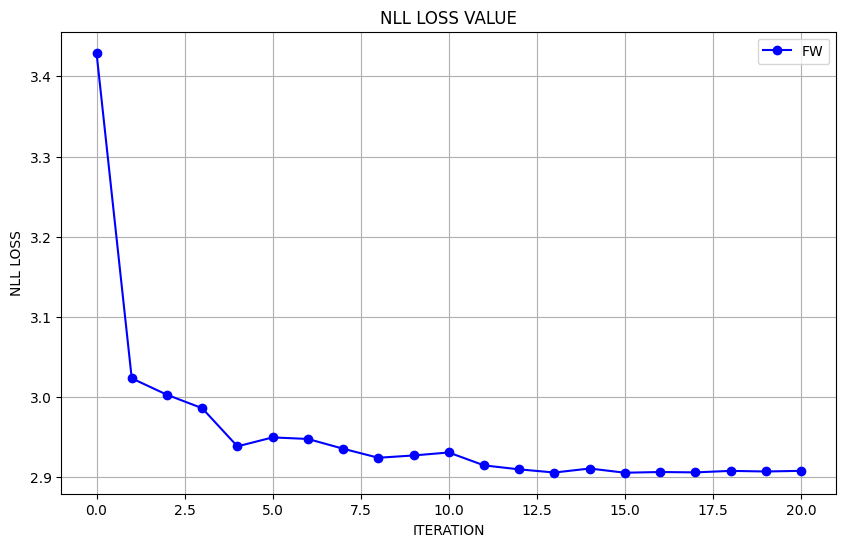

In [ ]:
MNL_problem, NLL_LIST = train_frank_wolfe(20, tr_offerset_list, tr_sell_list, tr_mask_list)
plt.figure(figsize=(10, 6))
plt.plot(NLL_LIST, marker='o', linestyle='-', color='b', label='FW')
plt.title('NLL LOSS VALUE')
plt.xlabel('ITERATION')
plt.ylabel('NLL LOSS')
plt.legend()
plt.grid(True)
plt.show()
